

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 7 - Generative Models - Autoencoders and GANs 



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman 


<hr style="height:2pt">

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit (excluding large networks)
- Please note that the model training in this assignment can take a long time (even on a GPU). Expect to train for more than 2-3hrs per model.

<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#PLEASE RUN THIS CELL 
import requests
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread
from scipy.misc import imresize
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, \
UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
import random

import glob
import skimage
import skimage.transform
import skimage.io
import cv2

from keras_preprocessing.image import ImageDataGenerator
from keras.layers import *
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

Using TensorFlow backend.


## Question 1: Making Faces [97 pts]  </b></div>

We'll be using a subset of the Celeb A dataset to help us build facial generative models, as described on the [Celeb A](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) website. CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. 

CelebA has large diversities, large quantities, and rich annotations, including

- 10,177 number of identities,
- 202,599 number of face images, 
- 5 landmark locations, and 
- 40 binary attributes annotations per image.

### Part A:  Preparing the Data [10 pts]

**1.A.1.** Download the dataset from: [CelebA Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip). In the provided data you'll see the `img_align_celeba` directory. The images in that directory will form your dataset.  You may want to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).  

In [3]:
class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, files, batch_size, target_height, target_width, conditioning_dim=0, conditioning_data=None):
        '''
        Intializes the custom generator.
        
        Args:
            files: The list of paths to images that should be fed to the network.
            batch_size: The batchsize to use.
            target_height: The target image height. If different, the images will be resized.
            target_width: The target image width. If different, the images will be resized.
            conditioning_dim: The dimension of the conditional variable space. Can be 0.
            conditioning_data: Optional dictionary that maps from the filename to the data to be
                conditioned on. Data must be numeric. Can be None. Otherwise, len must be equal to
                conditioning_dim.
        '''
        self.files = files
        self.batch_size = batch_size
        self.target_height = target_height
        self.target_width = target_width
        self.conditioning_dim = conditioning_dim
        self.conditioning_data = conditioning_data

    def on_epoch_end(self):
        '''Shuffle list of files after each epoch.'''
        np.random.shuffle(self.files)
        
    def __getitem__(self, index):
        cur_files = self.files[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(cur_files)
        return X, y
    
    def __data_generation(self, cur_files):
        X = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        Y = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        if self.conditioning_data != None:
            C = np.empty(shape=(self.batch_size, self.conditioning_dim))
        
        for i, file in enumerate(cur_files):
            img = skimage.io.imread(file)
            if img.shape[0] != self.target_height or img.shape[1] != self.target_width:
                img = skimage.transform.resize(img, (self.target_height, self.target_width)) # Resize.
            img = img.astype(np.float32) 
            X[i] = img
            Y[i] = img
            if self.conditioning_data != None:
                C[i] = self.conditioning_data[os.path.basename(file)]
                
        if self.conditioning_data != None:
            return [X, C], Y
        else:
            return X, Y
    
    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

In [4]:
# Find image files.
files = glob.glob('data/img_align_celeba/*.jpg')
# files = list(np.random.choice(files, size=10000, replace=False))
print(len(files), 'images found.')

202599 images found.


In [5]:
VARIATIONAL = True
HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 32
LATENT_DIM = 16
START_FILTERS = 32

In [6]:
gen = CustomDataGenerator(files=files, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH)

**1.A.2.** Load the attribute data in `list_attr_celeba.csv` into a pandas dataframe.

In [7]:
df = pd.read_csv('data/list_attr_celeba.csv')
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


**1.A.3.** Pick 3 random images from the dataset, plot them, and verify that the attributes are accurate.

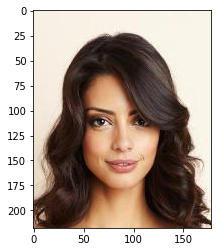

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
120528,120529.jpg,-1,1,1,-1,-1,1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [8]:
rnd_file = np.random.choice(files)
file_id = os.path.basename(rnd_file)
img = skimage.io.imread(rnd_file)
plt.imshow(img)
plt.show()

init_meta = df[df.image_id==file_id]
display(init_meta)

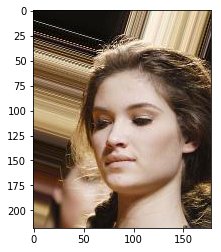

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
118082,118083.jpg,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1


In [9]:
rnd_file = np.random.choice(files)
file_id = os.path.basename(rnd_file)
img = skimage.io.imread(rnd_file)
plt.imshow(img)
plt.show()

init_meta = df[df.image_id==file_id]
display(init_meta)

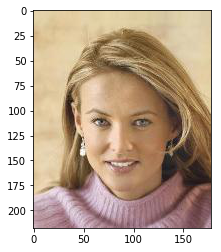

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
91985,091986.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,-1,-1,1,-1,1,-1,-1,1


In [10]:
rnd_file = np.random.choice(files)
file_id = os.path.basename(rnd_file)
img = skimage.io.imread(rnd_file)
plt.imshow(img)
plt.show()

init_meta = df[df.image_id==file_id]
display(init_meta)

I think most of the attributes are accurate, even though some attributes are quite subjective, like attractive. 

### Part B: Building and Training a Variational Autoencoder Model [44 pts]

**1.B.1.** Create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset.  Print summaries for the encoder, decoder and full autoencoder models.

In [11]:
def define_encoder_block(x, num_filters):  
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D()(x)
    return x

In [12]:
def define_decoder_block(x, num_filters):
    """
    Todo: Define one 2D upsampling layer (UpSampling2D) (you can keep default arguments).
          Also, define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

In [13]:
def define_net(variational, height, width, batch_size, latent_dim, conditioning_dim=0,
               start_filters=8):
    """Defines a (variational) encoder-decoder architecture.
    
    Args:
        variational: Whether a variational autoencoder should be defined.
        height: The height of the image input and output.
        width: The width of the image input and output.
        batch_size: The batchsize that is used during training. Must also be used for inference on the encoder side.
        latent_dim: The dimension of the latent space.
        conditioning_dim: The dimension of the space of variables to condition on. Can be zero for an 
            unconditional VAE.
        start_filters: The number of filters to start from. Multiples of this value are used across the network. 
            Can be used to change model capacity.
        
    Returns:
        Tuple of keras models for full VAE, encoder part and decoder part only.
    """
    
    # Prepare the inputs.
    inputs = Input((height, width, 3))
    if conditioning_dim > 0:
        # Define conditional VAE. Note that this is usually not the preferred way
        # of incorporating the conditioning information in the encoder.
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
        
    # Define the encoder.
    eblock1 = define_encoder_block(inputs_new, start_filters)
    eblock2 = define_encoder_block(eblock1, start_filters*2)
    eblock3 = define_encoder_block(eblock2, start_filters*4)
    eblock4 = define_encoder_block(eblock3, start_filters*8)
    _, *shape_spatial = eblock4.get_shape().as_list()
    eblock4_flat = Flatten()(eblock4)
    
    if not variational:
        z = Dense(latent_dim)(eblock4_flat)
    else:
        # Perform the sampling.
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon
        
        z_mean = Dense(latent_dim)(eblock4_flat)
        z_log_sigma = Dense(latent_dim)(eblock4_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    # Define the decoder.
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock4.shape.as_list()[1:])(embedding)
    
    dblock1 = define_decoder_block(embedding, start_filters*8)
    dblock2 = define_decoder_block(dblock1, start_filters*4)
    dblock3 = define_decoder_block(dblock2, start_filters*2)
    dblock4 = define_decoder_block(dblock3, start_filters)
    output = Conv2D(3, 1, activation = 'tanh')(dblock4)
    
    # Define the models.
    decoder = Model(input = inputs_embedding, output = output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model(input = [inputs, condition], output = z)
        encoder_with_sampling_ext = Model(input = [inputs, condition], output = z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model(input = [inputs, condition], output = vae_out)
    else:
        encoder_with_sampling = Model(input = inputs, output = z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(input = inputs, output = vae_out)
    
    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
        mse_loss = K.mean(keras.losses.mse(x, x_decoded_mean), axis=(1,2)) * height * width
        kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1) # -5e-4
        return mse_loss + kl_loss
    
    if variational:
        vae.compile(loss=vae_loss, optimizer='adam')
    else:
        vae.compile(loss='mse', optimizer='adam')    
    
    print('done,', vae.count_params(), 'parameters.')
    
    return vae, encoder_with_sampling, decoder

In [14]:
def encode_image(img, conditioning, encoder, height, width, batch_size):
    '''Encodes an image that is given in RGB-channel order with value range of [0, 255].
    
    Args:
        img: The image input. If shapes differ from (height, width), it will be resized.
        conditoning: The set of values to condition on, if any. Can be None.
        encoder: The keras encoder model to use.
        height: The target image height.
        width: The target image width.
        batch_size: The batchsize that the encoder expects.
        
    Returns:
        The latent representation of the input image.
    '''
    if img.shape[0] != height or img.shape[1] != width:
        img = skimage.transform.resize(img, (height, width))
    img_single = np.expand_dims(img, axis=0)
    img_single = img_single.astype(np.float32)
    img_single = np.repeat(img_single, batch_size, axis=0)
    if conditioning is None:
        z = encoder.predict(img_single)
    else:
        z = encoder.predict([img_single, np.repeat(np.expand_dims(conditioning, axis=0), batch_size, axis=0)])
    return z

In [15]:
def decode_embedding(z, conditioning, decoder):
    '''Decodes the given representation into an image.
    
    Args:
        z: The latent representation.
        conditioning: The set of values to condition on, if any. Can be None.
        decoder: The keras decoder model to use.
    '''
    if z.ndim < 2:
        z = np.expand_dims(z, axis=0) # Single-batch
    if conditioning is not None:
        z = np.concatenate((z, np.repeat(np.expand_dims(conditioning, axis=0), z.shape[0], axis=0)), axis=1)
    return decoder.predict(z)

In [16]:
def load_weights(folder):
    vae.load_weights(folder + '/vae.w')
    encoder.load_weights(folder + '/encoder.w')
    decoder.load_weights(folder + '/decoder.w')
    
def save_weights(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    vae.save_weights(folder + '/vae.w')
    encoder.save_weights(folder + '/encoder.w')
    decoder.save_weights(folder + '/decoder.w')

In [17]:
vae, encoder, decoder = define_net(variational=VARIATIONAL,
                                   height=HEIGHT, 
                                   width=WIDTH, 
                                   batch_size=BATCH_SIZE, 
                                   latent_dim=LATENT_DIM,
                                   start_filters=START_FILTERS)

done, 3736419 parameters.


In [18]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [19]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             278528    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 256)       0         
__________

In [20]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
model_2 (Model)              (None, 16)                1696576   
_________________________________________________________________
model_1 (Model)              (None, 128, 128, 3)       2039843   
Total params: 3,736,419
Trainable params: 3,736,419
Non-trainable params: 0
_________________________________________________________________


**1.B.2.** Train your model on the images in the celebA dataset.

In [21]:
# vae.fit_generator(gen, verbose=1, epochs=7)
# save_weights(folder='models/celeba_vae_full')

In [22]:
# I trained and saved model weights in the folder below.
load_weights('models/celeba_vae_full')

**1.B.3.** Choose a random input image.  Encode the image and then Decode the latent representation.  Plot the original image and the reconstructed output.  How do they compare?

latent sample:
 [-1.453647   -1.163708   -0.2652519   0.6670451   0.2861778  -0.07194141
 -0.0878744   0.6605689   0.24025117 -0.23390593  1.0922871   0.18089256
  0.9380422  -0.15924565 -0.11851126  0.33846545]


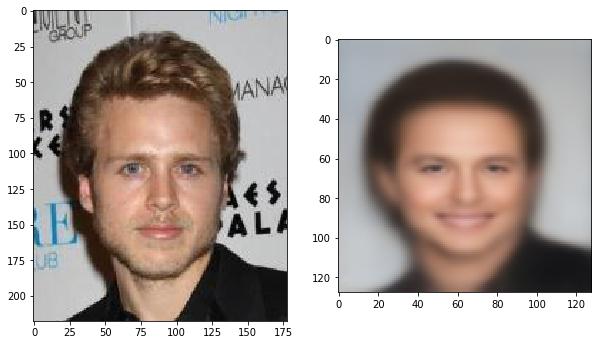

latent sample:
 [-0.63976693 -0.14634675 -0.44023338  0.02930867 -0.19757304 -0.29004806
 -0.11635195 -0.13232085 -0.3452685   0.7949826  -1.8409612   0.46917525
  0.05666112  0.20296499  0.3155882  -0.15347195]


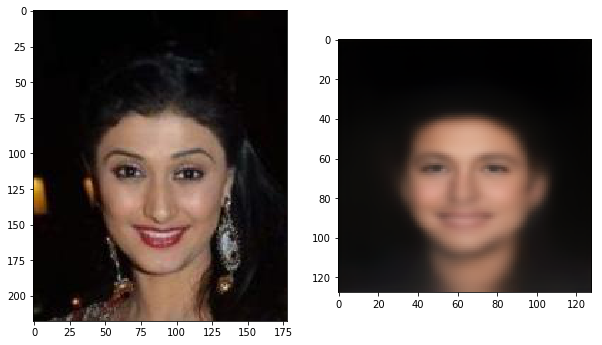

latent sample:
 [ 0.5975285   0.04404822 -2.187132   -0.17378211  0.22034664 -0.05780643
 -0.2060868   0.18818219  0.5698013   0.22895676  2.3336518   0.20302285
 -0.00461983 -0.01116885 -0.17222509  1.6181383 ]


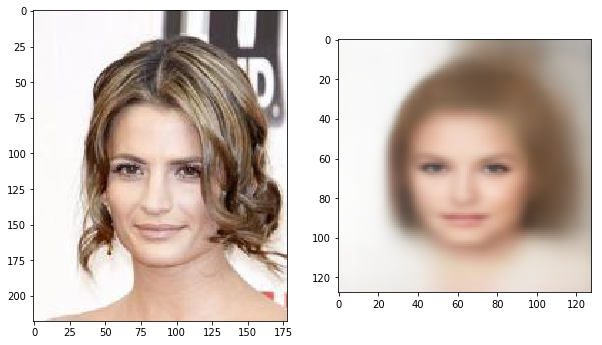

latent sample:
 [ 0.68904877 -0.43262032 -0.16549951 -0.18405214 -0.24844773  1.1270659
 -0.11586931 -0.48150706  0.02075912  1.4364051  -0.1878098  -0.12392135
  0.3314267   0.3542386   0.10886622 -0.41668698]


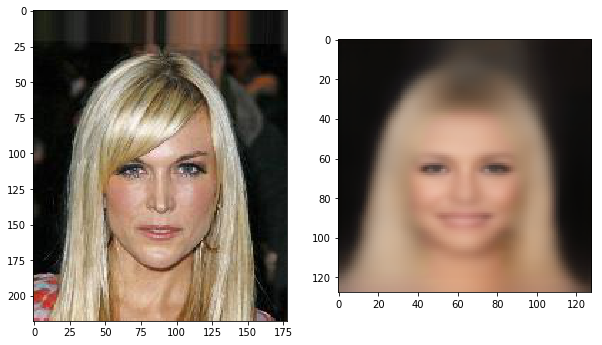

In [23]:
# Choose a random input file
np.random.seed(6)
for _ in range(4):
    rnd_file = np.random.choice(files)
    file_id = os.path.basename(rnd_file)
    init_meta = df[df.image_id==file_id]
    init_meta = list(init_meta.values[0][1:])
    img = skimage.io.imread(rnd_file)

    # Encode the image
    z = encode_image(img.astype(np.float32)/255., None, encoder, HEIGHT, WIDTH, BATCH_SIZE)
    print('latent sample:\n', z[0])

    # Decode the image
    ret = decode_embedding(z, None, decoder)

    # Compare the two plots
    f, ax = plt.subplots(1, 2, figsize=(10, 7))
    ax[0].imshow(img)
    ax[1].imshow(ret[0])
    plt.show()

I compared four images instead of one, and I found they are reasonably close. The generated pictures have all the key features kinda similar to the original pictures. 

**1.B.4.** Choose two celebrity faces from the dataset that differ according to two attributes and taking advantages of alterations of the latent representations image morph from one to the other.  See below for an example.

![](latent_1.png)

In [24]:
def display_manifold(decoder, height, width, base_vec, bound_x=15, bound_y=15, axis_x=0, axis_y=1, n=15,
                     desc_x = 'x', desc_y = 'y', file_out=None):
    '''Varies up to two dimensions of the latent representation, and visualizes its effect.

    This function can be used in one or two dimensions. To just vary a single dimension, set
    either bound_x or bound_y to zero.

    Args:
        decoder: The keras decoder model to use.
        height: The image height the decoder produces.
        width: The image width the decoder produces.
        base_vec: The basic latent representation to which changes should be applied.
            Per convention, the first entries in base_vec correspond to the latent variables,
            followed by variables we condition on (if any). Therefore, dimension is the sum of
            the latent dimension and the conditioning dimension.
        bound_x: The range that the values on axis_x will be modified to.
        bound_y: The range that the values on axis_y will be modified to.
        axis_x: The first axis to modify. Must be 0 <= axis_x <= len(base_vec).
        axis_y: The first axis to modify. Must be 0 <= axis_y <= len(base_vec).
        n: The number of columns/rows to generate. Thus, in total, n**2 images will be generated
            if two dimensions are modified. Otherwise, just n images will be generated.
        desc_x: The caption of the x-axis shown on the plot.
        desc_y: The caption of the y-axis shown on the plot.
        file_out: File path if the resulting plot should be saved. Can be None.

    Returns:
        Results will be plotted. In addition, a tuple is returned, containing both the grid as
        color image, as well as a list of the individual images generated (row-wise).
    '''
    figure = np.zeros((height * (n if bound_y > 0 else 1), width * (n if bound_x > 0 else 1), 3))
    grid_x = np.linspace(-bound_x, bound_x, n) if bound_x > 0 else [0]
    grid_y = np.linspace(-bound_y, bound_y, n) if bound_y > 0 else [0]
    individual_outputs = []

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = base_vec.copy()
            z_sample[axis_x] = xi # SD is 1
            z_sample[axis_y] = yi # SD is 1
            
            x_decoded = decoder.predict(np.expand_dims(z_sample, axis=0))
            sample = np.clip(x_decoded[0], 0, 1)
            figure[i * height: (i + 1) * height, j * width: (j + 1) * width] = sample
            individual_outputs.append(sample)

    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.xlabel(desc_x)
    plt.ylabel(desc_y)
    if file_out is not None:
        plt.savefig(file_out, dpi=200, bbox_inches='tight')
    return figure, individual_outputs


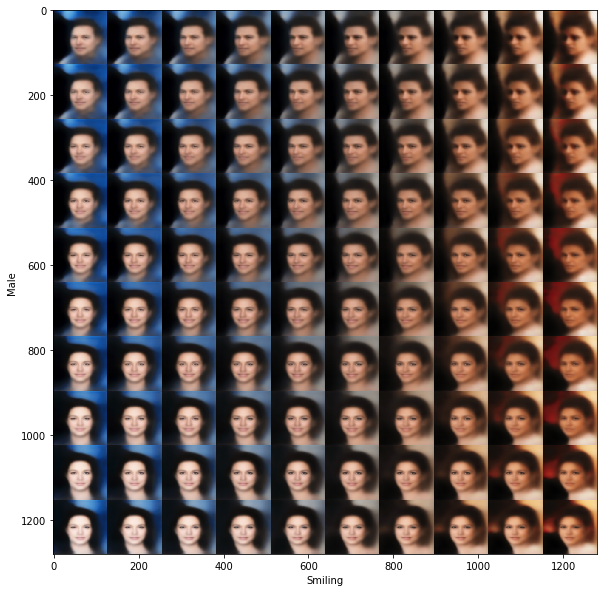

In [25]:
dim1 = 'Male' 
dim2 = 'Smiling'

img = skimage.io.imread('data/img_align_celeba/125526.jpg')
z = encode_image(img.astype(np.float32)/255, None, encoder, HEIGHT, WIDTH, BATCH_SIZE)
base_vec = np.array(list(z[0]))

rendering, _ = display_manifold(
    decoder, 
    HEIGHT, 
    WIDTH, 
    base_vec, 
    bound_x=2, 
    bound_y=2, 
    axis_x=1, 
    axis_y=14, 
    desc_x = dim2, 
    desc_y = dim1,
    n=10,
    file_out = 'rendering_celeba_' + dim1.lower() + '_' + dim2.lower() + '.png')

**1.B.5.** Generate and visualise around 15 celebrity faces not in your training set.  How do the generated faces compare in quality to celebrity faces from the training samples?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


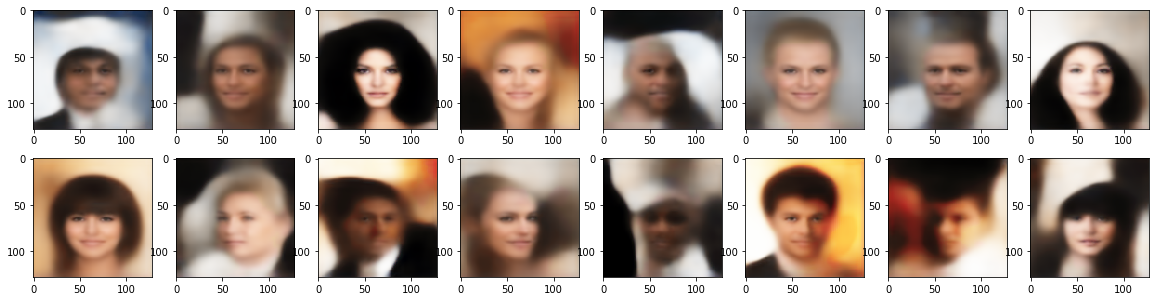

In [26]:
np.random.seed(1)
NUM_SAMPLES = 16
plt.figure(figsize=(20, 5))

for i in range(NUM_SAMPLES):
    noise = np.random.randn(1, LATENT_DIM) 
    pred_raw = decode_embedding(noise, None, decoder)[0]
    pred = (pred_raw * 0.5 + 0.5)
    plt.subplot(2, 8, i + 1)
    plt.imshow(pred_raw)
    
plt.show()

Even though the pictures above can capture the key features of faces, likes eyes, nose, sex, color, and hair style etc, the quality overall is stilll way worse than the quality of the training samples. Some of the faces are blured and they all lack the background details. I think the model can be improved by enhancing the architecture of the VAE, tuning better hyperparameters and training with more epoches. 

### Part C: Building and Training a DCGAN Model [43 pts]

**1.C.1.** Create and compile a DCGAN model for the celebrity faces dataset.  Print summaries for the discriminator and generator models.

In [27]:
SPATIAL_DIM = 64 # Spatial dimensions of the images.
LATENT_DIM = 100 # Dimensionality of the noise vector.
BATCH_SIZE = 32 # Batchsize to use for training.
DISC_UPDATES = 1  # Number of discriminator updates per training iteration.
GEN_UPDATES = 1 # Nmber of generator updates per training iteration.

FILTER_SIZE = 5 # Filter size to be applied throughout all convolutional layers.
NUM_LOAD = 10000 # Number of images to load from CelebA. Fit also according to the available memory on your machine.
NET_CAPACITY = 16 # General factor to globally change the number of convolutional filters.

PROGRESS_INTERVAL = 80 # Number of iterations after which current samples will be plotted.
ROOT_DIR = 'visualization' # Directory where generated samples should be saved to.

if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)

In [28]:
def add_encoder_block(x, filters, filter_size):
    x = Conv2D(filters, filter_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.3)(x)
    return x

In [29]:
def build_discriminator(start_filters, spatial_dim, filter_size):
    inp = Input(shape=(spatial_dim, spatial_dim, 3))
    
    # Encoding blocks downsample the image.
    x = add_encoder_block(inp, start_filters, filter_size)
    x = add_encoder_block(x, start_filters * 2, filter_size)
    x = add_encoder_block(x, start_filters * 4, filter_size)
    x = add_encoder_block(x, start_filters * 8, filter_size)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs=inp, outputs=x)

In [30]:
def add_decoder_block(x, filters, filter_size):
    x = Deconvolution2D(filters, filter_size, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.3)(x)
    return x

In [31]:
def build_generator(start_filters, filter_size, latent_dim):
    inp = Input(shape=(latent_dim,))
    
    # Projection.
    x = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
    x = BatchNormalization()(x)
    x = Reshape(target_shape=(4, 4, start_filters * 8))(x)
    
    # Decoding blocks upsample the image.
    x = add_decoder_block(x, start_filters * 4, filter_size)
    x = add_decoder_block(x, start_filters * 2, filter_size)
    x = add_decoder_block(x, start_filters, filter_size)
    x = add_decoder_block(x, start_filters, filter_size)    
    
    x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)
    return keras.Model(inputs=inp, outputs=x)

In [32]:
def construct_models(verbose=False):
    # 1. Build discriminator.
    discriminator = build_discriminator(NET_CAPACITY, SPATIAL_DIM, FILTER_SIZE)
    discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002), metrics=['mae'])

    # 2. Build generator.
    generator = build_generator(NET_CAPACITY, FILTER_SIZE, LATENT_DIM)

    # 3. Build full GAN setup by stacking generator and discriminator.
    gan = keras.Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False # Fix the discriminator part in the full setup.
    gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002), metrics=['mae'])

    if verbose: # Print model summaries for debugging purposes.
        generator.summary()
        discriminator.summary()
        gan.summary()
    return generator, discriminator, gan

In [33]:
def plot_image(x):
    plt.imshow(x * 0.5 + 0.5)

In [34]:
def run_training(start_it=0, num_epochs=1000):
    config_name = 'gan_cap' + str(NET_CAPACITY) + '_batch' + str(BATCH_SIZE) + '_filt' + str(FILTER_SIZE) + '_disc' + str(DISC_UPDATES) + '_gen' + str(GEN_UPDATES)
    folder = os.path.join(ROOT_DIR, config_name)

    if not os.path.isdir(folder):
        os.mkdir(folder)
    avg_loss_discriminator = []
    avg_loss_generator = []
    total_it = start_it

    for epoch in range(num_epochs):
        loss_discriminator = []
        loss_generator = []
        for it in range(200): 

            # Update discriminator.
            for i in range(DISC_UPDATES): 
                # Fetch real examples (you could sample unique entries, too).
                
                imgs_real = np.empty(shape=(BATCH_SIZE, SPATIAL_DIM, SPATIAL_DIM, 3))
                for i in range(BATCH_SIZE):
                    file = np.random.choice(files)
                    img = skimage.io.imread(file)
                    if img.shape[0] != SPATIAL_DIM or img.shape[1] != SPATIAL_DIM:
                        img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
                    img = img.astype(np.float32) / 127.5 - 1.0
                    imgs_real[i] = img
                    #plot_image(img)

                # Generate fake examples.
                noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
                imgs_fake = generator.predict(noise)

                d_loss_real = discriminator.train_on_batch(imgs_real, np.ones([BATCH_SIZE]))[1]
                d_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros([BATCH_SIZE]))[1]
            
            # Progress visualizations.
            if total_it % PROGRESS_INTERVAL == 0:
                plt.figure(figsize=(5,2))
                # We sample separate images.
                num_vis = min(BATCH_SIZE, 8)
                imgs_real = np.empty(shape=(num_vis, SPATIAL_DIM, SPATIAL_DIM, 3))
                for i in range(num_vis):
                    file = np.random.choice(files)
                    img = skimage.io.imread(file)
                    if img.shape[0] != SPATIAL_DIM or img.shape[1] != SPATIAL_DIM:
                        img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
                    img = img.astype(np.float32) / 127.5 - 1.0
                    imgs_real[i] = img
                    #plot_image(img)
                
                
                noise = np.random.randn(num_vis, LATENT_DIM)
                imgs_fake = generator.predict(noise)
                for obj_plot in [imgs_fake, imgs_real]:
                    plt.figure(figsize=(num_vis * 3, 3))
                    for b in range(num_vis):
                        disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                        plt.subplot(1, num_vis, b + 1)
                        plt.title(str(round(disc_score, 3)))
                        plot_image(obj_plot[b]) 
                    if obj_plot is imgs_fake:
                        plt.savefig(os.path.join(folder, str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                    plt.show()  

            # Update generator.
            loss = 0
            y = np.ones([BATCH_SIZE, 1]) 
            for j in range(GEN_UPDATES):
                noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
                loss += gan.train_on_batch(noise, y)[1]

            loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)        
            loss_generator.append(loss / GEN_UPDATES)
            total_it += 1

        # Progress visualization.
        clear_output(True)
        print('Epoch', epoch)
        avg_loss_discriminator.append(np.mean(loss_discriminator))
        avg_loss_generator.append(np.mean(loss_generator))
        plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
        plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
        plt.legend(['discriminator loss', 'generator loss'])
        plt.show()

In [35]:
generator, discriminator, gan = construct_models(verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_9 (Batch (None, 2048)              8192      
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 64)          204864    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

**1.C.2.** Train your model on the images in the celeba dataset.

Epoch 3


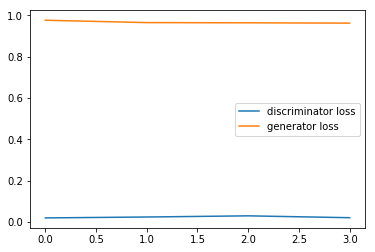

<Figure size 360x144 with 0 Axes>

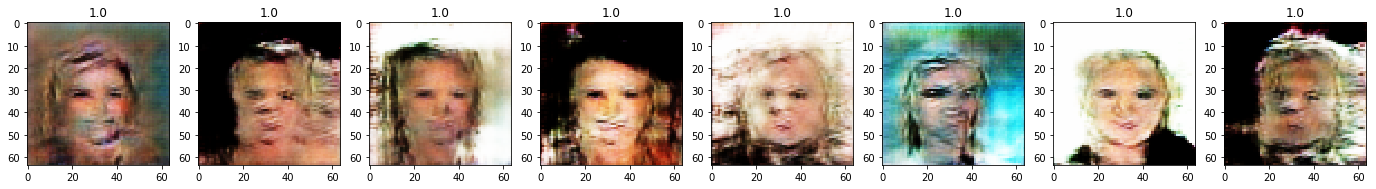

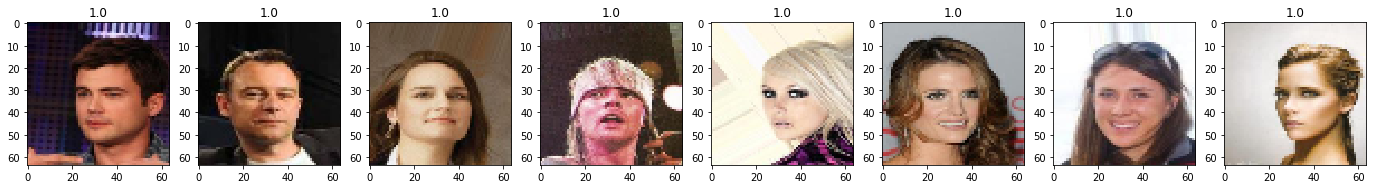

<Figure size 360x144 with 0 Axes>

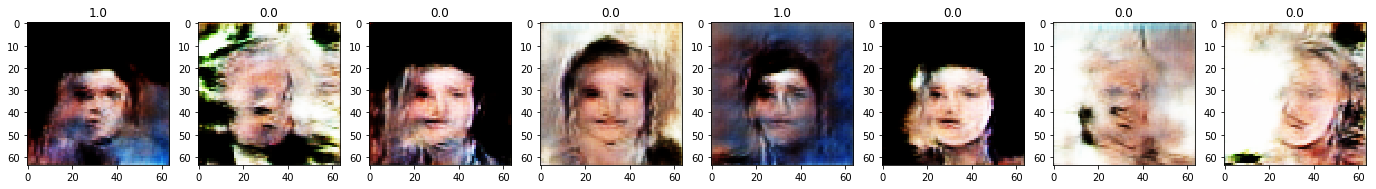

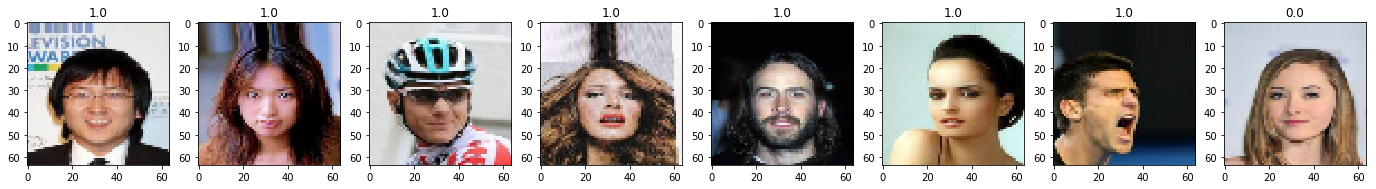

In [ ]:
# for i in range(200):
#     epochs = (i + 1) * 5
#     run_training(start_it=0, num_epochs=5)
#     gan.save_weights('models/celeba_gan/gan{}.w'.format(epochs))

In [36]:
gan.load_weights('models/celeba_gan/gan225.w')

**1.C.3.** Generate and visualise around 15 celebrity faces.  How do the generated faces compare in quality to celebrity faces from the training samples? How do they compare in quality to the faces generated via VAE?

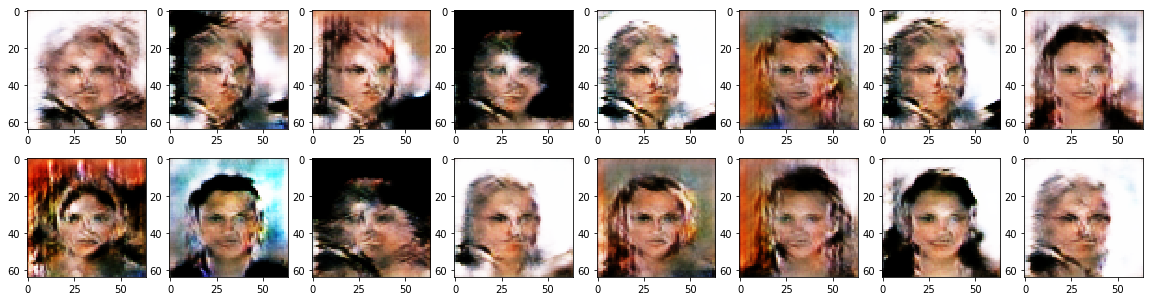

In [39]:
np.random.seed(0)
NUM_SAMPLES = 16
plt.figure(figsize=(20, 5))

for i in range(NUM_SAMPLES):
    noise = np.random.randn(1, LATENT_DIM) 
    pred_raw = generator.predict(noise)[0]
    pred = (pred_raw * 0.5 + 0.5)
    plt.subplot(2, 8, i + 1)
    plt.imshow(pred)
plt.show()

In term of quality ranking, training sample > the pictures generated from VAE > the pictures generated from GAN. The pictures from VAE are more real, have richer details, and are more like real pictures vs the pictures from GAN which are more like paints of art. With that being said, the images from GAN do have the key features of face, including eyes, hair, mouth, and nose etc. Given that the pictures are purely generated from noise, they are both quite impressive in my opinion.

## Question 2: VAE-GANIME [3 pts - ALMOST OPTIONAL] 

Wikipedia describes [Anime]() as follows:

Anime is hand-drawn and computer animation originating from or associated with Japan.  

The word anime is the Japanese term for animation, which means all forms of animated media. Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes. The culturally abstract approach to the word's meaning may open up the possibility of anime produced in countries other than Japan For simplicity, many Westerners strictly view anime as a Japanese animation product. Some scholars suggest defining anime as specifically or quintessentially Japanese may be related to a new form of Orientalism

We've provided you a dataset of anime faces and we want you to create a model to generate faces in the same style using a special form of GAN, a VAE-GAN.  The term VAE-GAN was first used by Larsen et. al in their paper [“Autoencoding beyond pixels using a learned similarity metric”](https://arxiv.org/abs/1512.09300).  VAE-GAN models differentiate themselves from GANs in that their generators are variation autoencoders.

![](https://cdn-images-1.medium.com/max/800/0*KEmfTtghsCDu6UTb.png)

### Part A: Preparing the Data 

**2.A.1.** Download the dataset from [Anime-Face Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip). It contains over 20K anime faces in the form of 64x64 images.  Use them to create your anime face dataset.  Again, you may find it to your advantage to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).

### Part B: Building and Training a DCGAN 

**2.B.1.** Create and compile a DCGAN model for the anime faces dataset.  Print summaries for the generator and discriminator models

**2.B.2.** Train your model on the images in the anime faces dataset.

**2.B.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples?

### Part C: Building and Training a VAE-GAN 

**2.C.1.** Create and compile a VAE-GAN model for the anime faces dataset.  Print summaries for the encoder, decoder and discriminator models

**2.C.2.** Train your model on the images in the anime faces dataset.

**2.C.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples? How do they compare to the faces from the traditional GAN?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs